# classification.cnn

> Fill in a module description here

In [ ]:
from monitosed.classification.core import *
from monitosed.data.core import *

from fastcore.xtras import Path
from tsai.all import *
from einops import rearrange, repeat

%load_ext autoreload
%autoreload 2

In [ ]:
users, labels = get_users_labels('../_data/Smarthy2_Behavioral.xlsx', drop_ixs=[0,2,7, 12, 13, 16])

In [ ]:
path = Path("../_data/foot1/Rest"); path.ls()

(#14) [Path('../_data/foot1/Rest/VR23_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR20_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR26_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR31_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR27_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR40_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR51_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR41_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR38_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR35_RestStim_data_clean.mat')...]

In [ ]:
mats = load_mats(path, 3)

  0%|          | 0/3 [00:00<?, ?it/s]

Loading: VR23_RestStim_data_clean.mat
Loading: VR20_Reststim_data_clean.mat
Loading: VR26_Reststim_data_clean.mat


In [ ]:
getters = [ItemGetter(0), ItemGetter(1)]

In [ ]:
valid_pct = 0.2
train_ix = int((1-valid_pct)*len(mats))

In [ ]:
#train_data = prepare_train_data(mats, train_ix)

In [ ]:
#Optional
signal_len = 1500

In [ ]:
data = prepare_train_data(mats)
if signal_len: data = data[..., :signal_len]
data.shape

(168, 173, 1500)

In [ ]:
read_mats = [read_data(mat) for mat in mats]
new_rearrange = partial(rearrange, pattern='d0 d1 d2 -> (d0 d1) d2')
rearranged_mats = [new_rearrange(mat) for mat in read_mats]

In [ ]:
x = torch.from_numpy(np.concatenate(data, axis=0)).unsqueeze(1)
y = np.concatenate([np.repeat(labels.values[i], rearranged_mats[i].shape[0]) for i in range(len(mats))])
x.shape, y.shape

(torch.Size([29064, 1, 1500]), (29064,))

In [ ]:
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [ ]:
n_train_sample = np.concatenate(rearranged_mats[:train_ix]).shape[0]

In [ ]:
splits = (np.arange(0, n_train_sample), np.arange(n_train_sample, len(x)))

In [ ]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(x, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)

In [ ]:
xb,yb = dls.one_batch(); xb,yb

(tensor([[[ 0.2108,  0.1261,  0.0985,  ..., -2.3576, -1.7510, -1.0727]],
 
         [[ 1.3280,  1.4398,  1.5988,  ...,  2.6372,  1.9485,  1.1603]],
 
         [[ 1.8887,  1.7433,  1.4770,  ..., -3.0836, -2.7960, -2.3194]],
 
         ...,
 
         [[-0.4133, -0.7122, -1.0061,  ..., -0.0374,  0.8565,  2.0192]],
 
         [[ 7.3648,  6.5977,  5.7735,  ...,  3.5563,  3.4836,  3.1976]],
 
         [[-0.6494, -0.5712, -0.3500,  ...,  3.2091,  2.9592,  2.6226]]],
        device='cuda:0'),
 tensor([1.0000, 1.3000, 1.3000, 1.3000, 1.0000, 1.0000, 1.0000, 1.0000, 1.3000,
         1.0000, 1.0000, 1.0000, 1.3000, 1.0000, 1.0000, 1.0000, 1.3000, 1.3000,
         1.0000, 1.3000, 1.3000, 1.0000, 1.3000, 1.0000, 1.0000, 1.0000, 1.3000,
         1.0000, 1.3000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.3000,
         1.0000, 1.3000, 1.3000, 1.3000, 1.3000, 1.3000, 1.3000, 1.0000, 1.0000,
         1.0000, 1.3000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.3000, 1.0000,
         1.0000, 1.0000

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, size_average=None, reduce=None, alpha=0.5, reduction: str = 'mean') -> None:
        super(CustomLoss, self).__init__()
        store_attr()

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        l1 = F.l1_loss(input, target, reduction=self.reduction)
        mse = F.mse_loss(input, target, reduction=self.reduction)
        return self.alpha*l1 + (1-self.alpha)*mse

SuggestedLRs(valley=0.0004786300996784121)

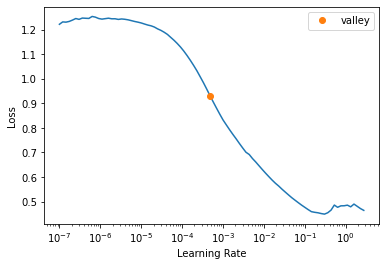

In [ ]:
learn = ts_learner(dls, InceptionTime, loss_func=CustomLoss(), metrics=[mae, rmse], cbs=ShowGraph())
learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.097351,20.863531,5.978811,5.978984,00:41
1,0.092938,20.839495,5.975148,5.975269,00:41
2,0.088180,19.900284,5.828542,5.828554,00:41
3,0.087890,20.167507,5.870635,5.870637,00:41
4,0.086565,19.936205,5.834224,5.834225,00:41


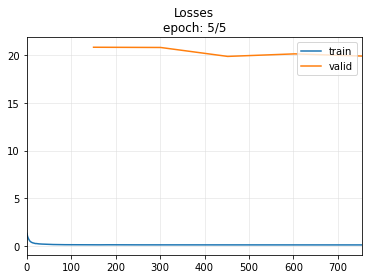

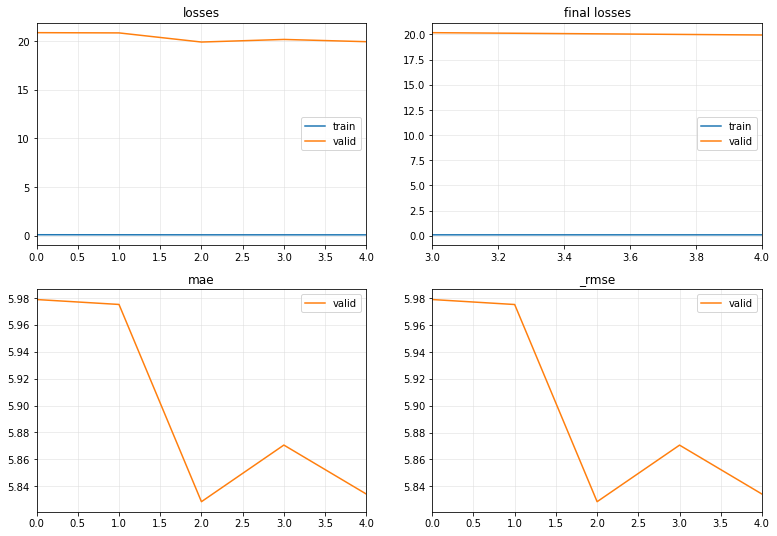

In [ ]:
learn.fit_one_cycle(5, 1e-2)